## Pairs Trading

Pairs Trading은 두 자산 간의 상대적인 가격 움직임을 이용하여 시장의 방향성과 무관하게 수익을 창출하는 시장 중립 전략(Market Neutral Strategy)이다. 두 자산이 장기적으로 평균회귀(Mean-Reverting) 특성을 가진다고 가정하고, 스프레드(spread)가 일정 수준 이상으로 벌어지면 차익 거래를 수행한다. 과제에 앞서, 미국의 IT섹터 내에 존재하는 임의의 두 자산 'GOOG','GOOGL'에 대하여 pairs trading을 수행하는 과정을 우선 보자.

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

data = yf.download(
    ['GOOG','GOOGL'],
    start = '2015-01-01',
    progress = False,
    interval = '1d',
    multi_level_index=False,
    auto_adjust=True
)

pairs trading을 위해서는, 두 자산이 비슷한 형태를 보여야 한다. 대개 동일 자산내에서 성격이 다른 주가(의결권이 있는 주식과 없는 주식 등) 사이에 pairs trading을 수행하며, 간혹 intra sector trading(동일 섹터 내 자산간 페어)을 수행하기도 한다.

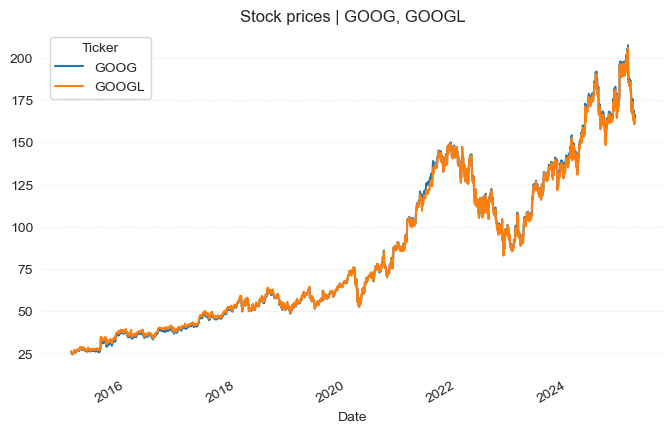

In [2]:
fig, ax = plt.subplots(figsize=(8, 5))
data['Close'].plot(ax=ax)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls=':', alpha=0.5)
plt.title(r'Stock prices | GOOG, GOOGL')
plt.show()

### Spread and Mean Reversion

두 개의 자산 $X_t$와 $Y_t$가 존재할 때, 이들의 선형 조합이 평균회귀성을 가지는 경우에 페어 트레이딩이 가능하다. 일반적으로 스프레드는 다음과 같이 정의된다.

$$S_t = Y_t - \beta X_t$$

여기서 $\beta$는 헤지 비율(Hedge Ratio) 로서, 두 자산 간의 균형 관계를 나타낸다. 만약 $S_t$가 공적분(Cointegration) 관계를 만족한다면, 이 스프레드는 정상성(Stationarity)을 갖고 평균으로 회귀하는 성질을 가진다.

**평균회귀성의 확인**

평균 회귀성을 가지는 확인하는 가장 간단한 방법은 바로 원 시계열에 대해 가격의 비율이 평균 회귀성을 갖는 그래프를 가지는지 확인하는 것이다.

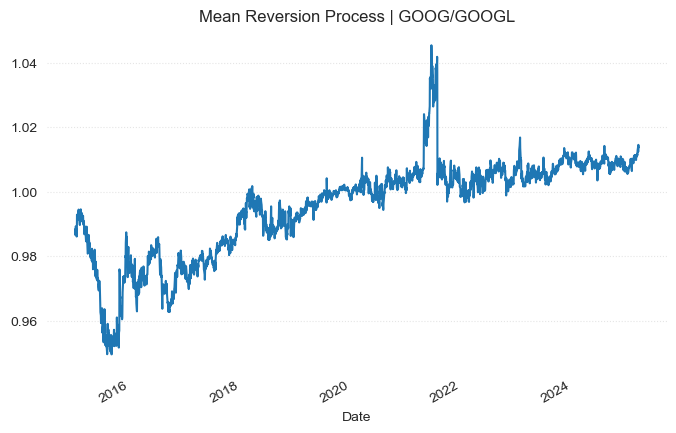

In [3]:
fig, ax = plt.subplots(figsize=(8, 5))
(data[('Close','GOOG')] / data[('Close','GOOGL')]).plot(ax=ax)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls=':', alpha=0.5)
plt.title(r'Mean Reversion Process | GOOG/GOOGL')
plt.show()

### 공적분 관계를 만족할 조건

1. $X_t \sim I(1)$과 $Y_t \sim I(1)$이고 (즉, 각각 비정상성(Non-Stationary)을 가진다)
2. 특정 선형 결합 $S_t = Y_t - \beta X_t$가 정상성을 가지면 $X_t$와 $Y_t$는 공적분 관계에 있다.

이 경우 $S_t$는 Ornstein-Uhlenbeck(O-U) 과정으로 모델링될 수 있다

$$dS_t = \theta (\mu - S_t)dt + \sigma dW_t$$

여기서 $\theta$는 평균회귀 속도 (Mean-Reverting Speed), $\mu$는 장기평균이며,  $\sigma$는 변동성, $W_t$는 Wiener 과정(Standard Brownian Motion)을 의미한다.

**비정상 시계열 검정**

$X_t \sim I(1)$과 $Y_t \sim I(1)$를 따르는지 확인을 하기 위해서는, ADF Test를 수행해 보아야 한다. ADF Test는 시계열이 정상성을 가지는지 검정하는 방법이며, 귀무가설은 "시계열은 비정상성을 가진다"이다. 만약, 검정을 기각한다면 해당 시계열은 정상성을 가진 process이다.

In [5]:
from statsmodels.tsa.stattools import adfuller

In [6]:
result = adfuller(data[('Close','GOOG')])

print(f"ADF Test for GOOG")
print(f"  ADF Statistic : {result[0]:.4f}")
print(f"  p-value       : {result[1]:.4f}")
print("  =>", "Non-stationary (I(1))" if result[1] > 0.05 else "Stationary (I(0))", "\n")

ADF Test for GOOG
  ADF Statistic : -0.4956
  p-value       : 0.8929
  => Non-stationary (I(1)) 



In [7]:
result = adfuller(data[('Close','GOOGL')])

print(f"ADF Test for GOOGL")
print(f"  ADF Statistic : {result[0]:.4f}")
print(f"  p-value       : {result[1]:.4f}")
print("  =>", "Non-stationary (I(1))" if result[1] > 0.05 else "Stationary (I(0))", "\n")

ADF Test for GOOGL
  ADF Statistic : -0.4873
  p-value       : 0.8945
  => Non-stationary (I(1)) 



**공적분 검정**

- python에서 공적분 검정은 `statsmodels.tsa.stattools`의 `coint` 함수를 통해 수행할 수 있다.
- p-value가 0.05미만일 경우 공적분을 갖지 않는다는 귀무 가설을 기각하며, 이 경우 두 시계열이 공적분 관계에 있다고 볼 수 있다.

In [20]:
from statsmodels.tsa.stattools import coint # 공적분 검정을 위한 statsmodels class

score, p_value, _ = coint(data[('Close','GOOG')], data[('Close','GOOGL')])
print('Correlation : %.4f' % data[('Close','GOOG')].corr(data[('Close','GOOGL')]))
print('Cointegration test p-value : %.4f' % p_value)
print('Cointegration test score : %.4f'  % score)

Correlation : 0.9999
Cointegration test p-value : 0.0000
Cointegration test score : -5.4065


### Estimate Hedge Ratio $(\beta)$

헤지 비율 $\beta$는 회귀분석을 통해 추정할 수 있다. 대표적인 방법으로는 최소제곱법(OLS, Ordinary Least Squares) 을 이용한 선형 회귀가 있다

$$Y_t = \alpha + \beta X_t + \varepsilon_t$$

회귀 분석 결과로 $\beta$를 추정한 후, 스프레드 $S_t$를 계산한다.

In [4]:
matrix = pd.concat(
    [data[('Close','GOOG')].pct_change(), data[('Close','GOOGL')].pct_change()],
    axis = 1
).dropna()
matrix.columns = ['GOOG','GOOGL']

In [9]:
import statsmodels.api as sm

Y = matrix["GOOG"]
X = matrix["GOOGL"]
X_const = sm.add_constant(X)

model = sm.OLS(Y, X_const).fit()

In [10]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   GOOG   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                 2.242e+05
Date:                Mon, 24 Mar 2025   Prob (F-statistic):               0.00
Time:                        00:36:01   Log-Likelihood:                 12433.
No. Observations:                2569   AIC:                        -2.486e+04
Df Residuals:                    2567   BIC:                        -2.485e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.442e-05   3.78e-05      0.381      0.7

In [11]:
beta = model.params["GOOGL"]

print(f"Hedge Ratio (β): {beta:.3f}")

Hedge Ratio (β): 0.995


GOOG과 GOOGL는 
- 각 시계열의 가격 시계열(원 시계열)이 $I(1)$인 정상성을 가지지 않은 시계열이며
- 차분 시계열(수익률)에 대해 공적분 관계를 가지고 있으며
- 각 자산간 수익률에 대해 OLS 모델에서 beta가 유의할 정도로 관계가 있으므로

두 자산은 pairs trading에 적합한 자산이다.

### Trading Signal

스프레드 $S_t$가 정상성을 갖는다면, 평균회귀 특성을 이용하여 트레이딩을 수행한다. 다음과 같이 Z-score 를 계산하여 매매 시그널을 설정한다.

$$Z_t = \frac{S_t - \mu_S}{\sigma_S}$$

$\mu_S$는 스프레드의 이동평균이고, $\sigma_S$는 스프레드의 이동표준편차이다.

**spread의 계산**
 
spread는 다음과 같은 과정으로 계산된다. 자산 가격 간의 선형 조합이 정상성을 가지는 특수한 경우이므로, 스프레드 계산에는 자산의 원 가격에 beta만이 사용된다.

In [12]:
spread = data[('Close','GOOG')] - beta * data[('Close','GOOGL')]

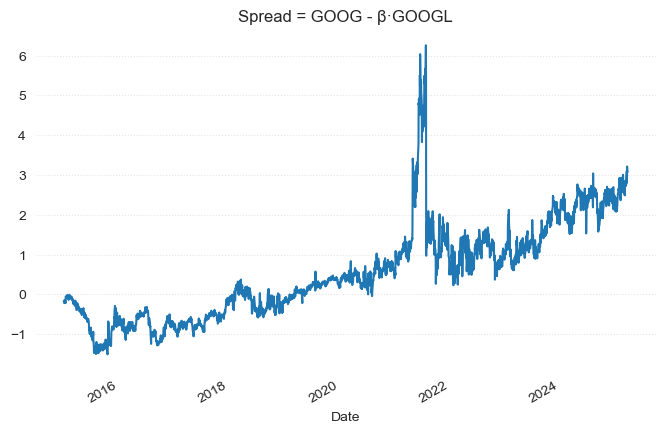

In [13]:
fig, ax = plt.subplots(figsize=(8, 5))
spread.plot(ax = ax)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls=':', alpha=0.5)
plt.title(r'Spread = GOOG - β·GOOGL')
plt.show()

**Z-score 계산**

spread는 높은 확률로 장기간에 걸쳐 평균 회귀하지 않은 특성이 있는데, 이는 자산 가격 자체가 시간이 지남에 따라 커지기 때문이다. 따라서, 스프레드는 점진적으로 우상향한다.

이 같은 사실 때문에 spread를 전략에 바로 사용할 수는 없으며, 신호로 만들어내기 위해서는 기간에 따른 표준화를 진행해야 한다.

In [14]:
window = 60 # 신호를 만들 때, Z score를 계산하기 위한 기간 지정

rolling_mean = spread.rolling(window).mean()
rolling_std = spread.rolling(window).std()

# Z-score
z_score = (spread - rolling_mean) / rolling_std

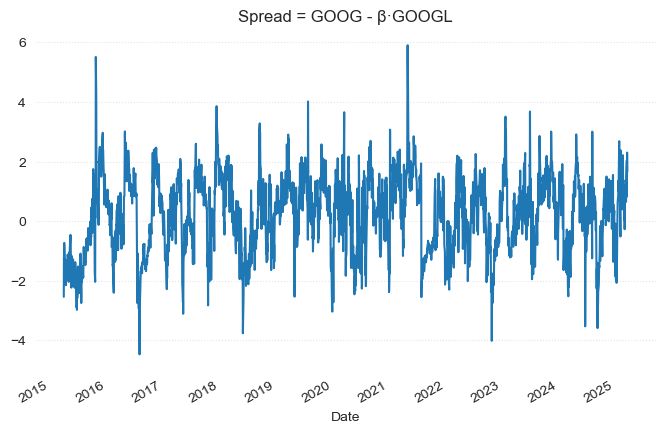

In [15]:
fig, ax = plt.subplots(figsize=(8, 5))
z_score.plot(ax = ax)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls=':', alpha=0.5)
plt.title(r'Spread = GOOG - β·GOOGL')
plt.show()

**position 계산**

스프레드에 따라서 포지션을 설정한다. entry threshold는 z score에서 각 방향(short, long)의 진입 구간을 지정하며, exit threshold는 포지션 청산 시점을 지정한다.

여기서 spread long은 OLS식에서의 Y자산(이 예제에서는 GOOG)을 매수, X자산을 매도하는 것을 의미하고, spread short은 OLS 식에서의 X자산(이 예제에서는 GOOGL)을 매수, Y자산을 매도하는 것을 의미한다.

In [16]:
entry_threshold = 2
exit_threshold = 0.5

signals = pd.DataFrame(index=spread.index)
signals["spread"] = spread
signals["z_score"] = z_score
signals["position"] = 0

# 포지션 정의
signals.loc[z_score > entry_threshold, "position"] = -1  # 스프레드 숏
signals.loc[z_score < -entry_threshold, "position"] = 1  # 스프레드 롱
signals.loc[z_score.abs() < exit_threshold, "position"] = 0  # 청산

# 포지션 유지
signals["position"] = signals["position"].replace(to_replace=0, method="ffill")

/var/folders/1q/pl9tj55n57s9jg28npxw61n80000gn/T/ipykernel_10751/1985983757.py:15: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  signals["position"] = signals["position"].replace(to_replace=0, method="ffill")


**Historical Simulation**

역사적 백테스팅을 수행한다. 신호가 확인된 이후 진입한다고 가정해야 하기 때문에, 실제 포지션은 signal의 포지션에서 하루를 미룬다.

In [17]:
positions = signals["position"].shift()

spread long인 경우 Y매수, X매도를 진행하고, spread short인 경우 Y매도, X매수를 진행한다.

In [18]:
# 스프레드 수익률 계산
# Spread = Y - βX 이므로, spread 롱 → Y 롱, X 숏
spread_ret = positions * (matrix["GOOG"] - beta * matrix["GOOGL"])
spread_ret.name = "strategy_return"

# 누적 수익률
cumulative_return = (1 + spread_ret.fillna(0)).cumprod()

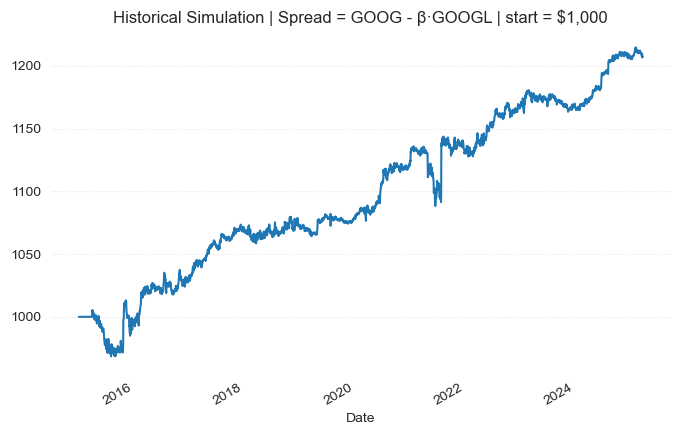

In [19]:
fig, ax = plt.subplots(figsize=(8, 5))
(cumulative_return * 1000).plot(ax = ax)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls=':', alpha=0.5)
plt.title(r'Historical Simulation | Spread = GOOG - β·GOOGL | start = $1,000')
plt.show()


### Conclusion

Pairs Trading은 두 자산 간의 공적분 관계를 이용한 평균회귀 전략으로, 시장의 방향성과 관계없이 수익을 창출할 수 있는 강력한 전략이다. 그러나 자산 간의 공적분 관계가 지속적으로 유지되는지 검증해야 하며, 변동하는 시장 환경에 대응하기 위해 다이내믹 헤지 비율과 리스크 관리 기법을 병행해야 한다.

## Practice 1

이번 과제에서는 실제 자산 가격 데이터 두 개를 입력하여 위에서 논의한 pairs trading 전략을 수행해 보는 것으로 합니다. 각 자산은 다음의 규칙에 맞아야 합니다.

- 두 자산간 공적분 관계가 존재한다.
- 두 자산의 각각의 시계열은 $I(1)$계열의 불안정 시계열이여야 한다.
- 두 자산은 모두 short selling(공매도)가 가능하거나, short position(매도 포지션)이 가능해야 한다.
- 한 자산이 완벽하게 매도가 불가능할 경우, 역사적으로 매도 포지션과 correlation이 매우 큰 대체 자산이 존재해야 한다.
    - 예시 : TSLA의 경우, TSLZ와 같은 short ETF를 사용할 수 있다.
- 한국 종목을 사용하는 경우, 공매도 금지 기간에 대한 규제는 일단 무시한다.
- 두 자산 모두 거래를 수행하기 위한 충분한 거래량이 있어야 한다.

위 코드를 보고 프로세스를 수행한 뒤, 아래의 질문에 답하세요.

### 1.1 Overfitting

수행한 과제를 다음의 일련의 과정에 따라 다시 한 번 수행해 봅시다.

- 수행 기간에서 최근 2년을 제외한 나머지 과거 기간을 학습 기간으로 잡고, 최근 2년을 테스트 기간으로 사용합니다.
- hedge ratio를 학습 기간에서 추정한 뒤, 거래 전략의 시뮬레이션은 최근 2년으로 한정합니다.

위 규제를 추가하여 pairs trading을 수행할 경우, 성과는 위에서 행한 결과와 달라졌습니까? 변했다면, 성과는 전체 기간에 대해 수행한 것과 비교했을 때 성과가 하락하였습니까?

### 1.2 Dynamic Hedge Ratio

수행한 과제를 다음의 일련의 과정에 따라 다시 한 번 수행해 봅시다.
- 수행 기간에서 초반 2년의 데이터를 hedge ratio 추정에 사용하고, 이 비율을 향후 1년간 사용합니다.
- 동일한 방법으로 그 다음 해가 되면 3년전부터 1년전까지의 데이터를 hedge ratio 추정에 사용하고, 가장 가까운 과거의 1년 데이터에 적용합니다.

위 과정을 반복하여 시뮬레이션을 수행할 경우, 성과는 위에서 행한 결과들과 어떤 차이를 보이나요?

### 1.3 Conclusion

실제로 위 과정을 거래에 사용할 경우, 주의해야 할 점은 무엇인가요? 또한, 발생할 수 있는 리스크는 어떤 것들이 있을까요?